In [1]:
from pprint import pprint

dx = 0.001
dy = 0.001
n = 10

def get_size(dx, dy, n):
    return {
        'L_mot' : 5*dx,
        'l_mot' : dy,
        'L_1' :  2*dx,
        'l_1' : dy,
        'L_2' : 4*dx,
        'l_2' : n*dy,
        'delta_vert_12' : dy,
        'L_vacuum' : 5*dx,
        'l_vacuum' : dy,
        'res_x': 2*(n+4),
        'res_y': 5
    }

pprint(get_size(dx,dy,n))

SyntaxError: invalid syntax (<ipython-input-1-9ac8f8ed9dd9>, line 22)

In [ ]:
from main import split, reversed_lines
import csv
split(open("results/thruster/1.csv", 'r'), iterations = 500, index = -1, expected_lenght = 9, idx_to_delete = [5,6], output_name_template='output_%s.csv', output_path='results/thruster/')

In [ ]:
N_perma = 25000 # number of particles in the system in steady flow
target_space = 1000 # number of Mo to use for saving the given test

def size_one_save(N, target_space = None, nb_iterations = None, saving_period = None, with_processing = False, as_csv = True):
    from pprint import pprint
    V = 6
    if(as_csv):
        W = (6*22+1+2)/6 # if float32 are saved as str, which is the case in csv, then, we can expect something of this magniture. 
        # I should maybe make sure I am using scientific notation..
        if(with_processing): # for norm and norm squared
            W+=22*2/6
    else:
        W = (6*4+1+2)/6
        if(with_processing):
            W+=4*2/6
    # which yields :
    size = N*(V*W+4)/1024**2
    
    out = {
        'N':N,
        'Size one save (MB)':size
    }
    
    if(nb_iterations != None):
        if(saving_period != None):
            size *= nb_iterations//saving_period
            out['Nb iterations']=nb_iterations
            out['Saving period']=saving_period
            out['Nb saves (induced)']=nb_iterations//saving_period
            out['Total size (induced)(MB)']=size
        else:
            size *= nb_iterations
            out['Nb iterations']=nb_iterations
            out['Saving period']=1
            out['Nb saves (induced)']=nb_iterations
            out['Total size (induced) (MB)']=size
    else:
        if(saving_period != None and target_space != None):
            nb_saves = int(target_space/size)
            nb_iterations = nb_saves*saving_period
            out['Nb iterations (induced)']=nb_iterations
            out['Saving period']=saving_period
            out['Nb saves (induced)']=nb_saves
            out['Total size (MB)']=target_space
    pprint(out)
    return out



In [ ]:
# thruster 1 - steady state
size_one_save(N=25000, nb_iterations = 20000, saving_period = 50) # per day : 5000

In [ ]:
# thruster 1 - x4 cells
size_one_save(N=100000, nb_iterations = 2000, saving_period = 10) # per day : 500

In [ ]:
# tube 1 - steady state
size_one_save(N=11000, nb_iterations = 20000, saving_period = 50) # per day : 20000

In [ ]:
size_one_save(N=11000, nb_iterations = 2000, saving_period = 4, with_processing=True)

<div style="text-align: center; font-weight: bold; font-size: 200%"> Negative ions ray neutralization for satellite propulsion</div><br />
<div style="text-align: center;  font-style: italic; font-weight: bold; font-size: 220%"> Direct Simulation Monte Carlo </div><br />
<!--  <div style="text-align: center; font-size: 120%">Laboratoire de Physique des Plasmas - Ecole polytechnique</div><br /> -->
<div style="text-align: center; font-size: 150%"><img src="https://www.lpp.polytechnique.fr/IMG/logo_LPP.png" width="240" height="240" align="center"/></div>

## Algorithm

For each time step $\Delta t$, 2 phases :
#### Advection phase : 
Particles are moved as if they did not interact. Particles that reach a boundary are processed accordingly.
#### Collision phase : 
For each cell, we compute a given number of collisions $M_{coll}$.
1. Choose two particles $i$ and $j$, in the cell, randomly.
2. Compute the collision probability which is proportional to their relative speed and depends on the **maximum relative speed** in the cell which for computational reasons should be estimated.
3. If the pair is accepted, the collision is processed with new velocities depending on the previous one and some randomness.
4. The routine moves again to step 1, until $M_{coll}$ is reached.

## Remarks :
- It is necessary to have enough particles (at least $20$ according to literature) per cell for the validity of the algorithm.
- One of the key point  is estimating the **maximum relative speed** in each cell.
- A simulated particle represents much more physical particles allowing a simulation to take place with roughly $10^4$ particles.

## Principles

- Choose $\Delta t$ so that it is a fraction of the **mean free time**.
- Choose $\Delta x = \Delta y$ (for square cells here) so that it is less that the **mean free path** $\lambda$.

### Calculating $\lambda$ - the mean free path 
By definition : 
$\lambda = \frac{1}{\sqrt{2}{} \pi d^2n}$ for a maxwellian distribution.

With : 
- $d$ : effective diameter of the particle. We choose : $d \approx 4 \times 10^{-10} \space m$ which is the diameter of $I_2$.
- $n$ : density of particules. We choose : $n = [I] \approx 10^{20} \space m^{-3}$.

That yields : $\lambda \approx 0.014 \space m$.

 **Note** : 
- $L \approx 0.005 \space m$.
- We can then compute the **Knudsen** number : $K_n = \frac{\lambda}{L} \approx 2$. It is considered that a continumm description is not accurate when $K_n > 0.1$.

The mean speed of $I$ is roughly $v=3 \times 10^2 \space m.s^{-1}$. Using the mean free path, that yields : $MeanFreeTime \approx 4.8 \times 10^{-5} \space s$ requiring $\Delta t \leq 1.2 \times 10^{-5} \space s$.

# Computation of the number of candidates that should be selected for collisions in a **homogeneous gas**

We have the number of collisions we should process per unit of time : $M_{coll} = \frac{1}{2} \nu_c N dt$, with $\nu_c$ the collision rate for one particle and $N$ the number of particles considered.

$\Rightarrow$ Not optimal to select this number of collisions per $dt$. The probability of collisions is very low afterwards. 

Thus, what we can do is selecting only a number of pairs to compute collisions with and hope that in average we have the same number of collisions. This is an approximation.

The choice that is optimal, is to divide all probability by the maximum probability of collision $P_{max} = \frac{v_{r,max}}{<v_{r}>}$. Which means that $\hat{P}_{i,k} = P_{i,k}/P_{max}$. 

And thus, selecting $M_{cand} = P_{max} M_{coll}$ candidate pairs per unit of time yields in average to the same number of computed collisions : 

$$<\hat{M}_{coll}> = <\sum_{k=0}^{M_{cand}}  \frac{v_{r,k}}{v_{r,max}}> = \frac{\sum_{k=0}^{M_{cand}}}{v_{r,max}}  <v_{r,k}> = \frac{M_{cand}}{v_{r,max}}  <v_r> = M_{coll}$$


However, the hypothesis was that $M_{cand}$ remains the same. Even if we suppose $P_{max}$ was fixed by the user to the maximum value it can encounter (which would not be the optimal value), then $M_{coll}$ can still change. 

Let's first find a better expression for $M_{coll} = \frac{1}{2} \nu_c N dt$.

We have : $\nu_c = \frac{1}{\tau} = \frac{<v_r>}{\lambda} = <v_r> \frac{N}{V} \sigma$ with $\sigma = \pi d^2$ the cross section (which can be simplify for a Maxwellian distribution).

Thus, $M_{coll} = \frac{1}{2} <v_r> \sigma \frac{N^2}{V} dt$.

If now, we apply it for the simulation, where : 
* $V = V_c$, the volume of a cell ;
* $N = N_c$, the number of particle in one cell.

We have : 

 $$ M_{coll} =  \frac{1}{2} <v_r> \sigma \frac{N_c^2}{V_c} dt $$


# Probability of collision

For a given cell containing $N_c$ particles, the number of pairs selected is :

$$M_{cand} = \frac{ \pi N_c \bar{N_c} d^2 v_{r,max} N_e}{2V_c} \Delta t$$ 

Where : 
* $\bar{N_c}$ is, for now, set at the start of the simulation and equals to : $\frac{\text{number of particles}}{\text{number of cells}}$ ;
* $d$ is the effective diameter (here : $4\times10^{-10}$ m) ;
* $v_{r,max}$ is the estimation of the maximum relative norm speed, here $600$ $m.s^{-1}$;
* $N_e$ is the number of real particles a simulated particle represents, here roughly $2 \times 10^{14}$ ;
* $V_c$ is the volume of the cell. 
* $\Delta t$ the time step.

The probability of collision for a given pair $(i,j)$ is then equals to : $\frac{v_{r, norm}}{v_{r,max}}$ where : $v_{r, norm} = \|v_j - v_i\|$.


# Simulation parameters
* $[I] = 10^{20}$ $m^{-3}$
* $ d = 4\times10^{-10}$ $m$
* $v_{mean} = 3\times 10^2$ $m.s^{-1}$ and $v_{r,max} = 2v_{mean}$

This allows to compute the **mean free time** and the **mean free path**.


* $dt = 0.25 \times MeanFreeTime = 1.17 \times 10^{-5}$ $s$.
* Mean number of particles per cell : $100$ or $200$.
* Number of cells : $N_{c,x} = 3$ ; $N_{c,y} = 3$ which makes $9$ cells. The size of the grid is then computed using the **mean free path** $\lambda$: $(\lambda N_{c,x},\lambda N_{c,y}, l_z)$ where $l_z = 0.1$ m. The total volume is thus : $0.042 \times 0.042 \times 0.1 = 1.7 \times 10^{-5}$ $m^{-3}$.



## Three types of initialization for speed :
* Uniform  : each $v_x$, $v_y$ and $v_z$ is choosen uniform on $[-m,M]$, $m=M$. The law of  $V = \sqrt{{v_x}^2+{v_y}^2+{v_z}^2}$ can be obtained with geometric arguments (more below).
* Uniform on speed norm : $V = \sqrt{{v_x}^2+{v_y}^2+{v_z}^2}$ is choosen uniformy on $[m,M]$.
* Gaussian : each $v_x$, $v_y$ and $v_z$ is choosen along a gaussian distribution with $\sigma = \sqrt{\frac{k_bT}{m_i}}$ (where $m_i$ is the mass of the particle, here they are all the same) and $\mu = 0$. The distribution of  $V = \sqrt{{v_x}^2+{v_y}^2+{v_z}^2}$ is a maxwellian one.


# Explaination - law of  $V = \sqrt{{v_x}^2+{v_y}^2+{v_z}^2}$


For instance, 
* $\mathbb{P}(V < v) = 0$ for $v<0$.  
* $\mathbb{P}(V < v) = \frac{\text{Volume of the sphere of radius }v \text{ centered in }0}{m^3} = \frac{\frac{4}{3}\pi v^3}{m^3}$ for $0 \leq v \leq m$. 
* $\mathbb{P}(V < v) = ...  $ for $\sqrt{3}m > v > m$.
* $\mathbb{P}(V < v) = 1$ for $\sqrt{3}m < v$.

This yields : $\mathbb{E}(V)=$

# Results

### Maxwellian norm init
Once the norm $V$ has been choosen, we randomly select $\phi$ and $\theta$ in $[0,2\pi[$ and then :=> NO
* $v_x = V sin(\theta) cos(\phi) $
* $v_x = V sin(\theta) sin(\phi) $
* $v_x = V cos(\theta) $

# Collision frequency

* Number of collisions during simulation : $20089$ collisions ; 
* $N_e \approx 9.9 \times 10^{11}$ particles ;
Which yields : $2.0 \times 10^{17}$ 'real' collisions during the simulation.

Then, the number of collisions per unit of time, per unit of volume in theory is given by : $z = \frac{n}{2} \frac{\bar{v}}{\lambda}$.

We have : 
* $n = 10^{20}$ $m^{-3}$ ;
* $\bar{v} = 276.64$ $m.s^{-1}$ at the beginning of the simulation. It remains the same as the system is conservative ;
* $\lambda = 1.4 \times 10^{-2}$ $m$ ;

Which yields for a volume of $1.8 \times 10^{-4}$ $m^3$ and a elapsed time of $3.51 \times 10^{-3}$ $s$ to $6.2 \times 10^{17}$ collisions.


##  Modelization of temperature evolution for non maxwellian initializations

We are looking to modelize the standard deviation of the temperature distribution with the relation :
$$\sigma^2(t) = (\sigma^2(0) - \sigma^2_{eq})e^{-t/\tau}+\sigma^2_{eq}$$

Evolution fo temperature in the simulation, for each time step $n$: 
1. We define $w_n = v_n - <v_n>$
2. Which yields : $\sigma^2_n = <w_n^2>$ which is an approximaton of the variance of the random variable $V_n$ by definition.

Since the system is a conservative one, we can compute $<v_{0}^2>$, an approximation of the 2nd order moment of the random variable $V_0$ by definition. Then, if we suppose the thermal equilibrium, we can compute the scale parameter in the Maxwell distribution : $a = \sqrt{\frac{kT}{m}} =  \sqrt{\frac{<v_{0}^2>}{3}}$ for dimension thre. Which yields the variance :  $\sigma_{eq} = \frac{a^2(3\pi-8)}{\pi}$.

Then we minimize $|\sigma^2_n -\big[(\sigma^2(0) - \sigma^2_{eq})e^{-t/\tau}+\sigma^2_{eq}\big]|$ w.r.t. to $\tau$.

## Flux injection

### Normal distribution :


- For the case of ions / electrons that have been accelerated using electric fields in the direction $x_1$, then $x_2$ and $x_3$ should be treated as 'normal' maxwellian distribution and $x_1$ should be 

## Maxwellian flux

Value taken :
* Flux speed : $v_{flux} = 50$ $m.s^{-1}$
* Flux is computed using : $\Gamma = \frac{1}{4} n S_{in} \bar{v} + n S_{in} v_{flux}$ with : $\bar{v} = \sqrt{\frac{8kT}{\pi m}}$
* temperature : 300 K
* $n = 3.2 \times 10^{19}$ $m^{-3}$
* $S_{in}$ = $l_{\text{in-wall}} \times l_z$ with $l_z = 1$ $mm$. 

For the tube system : $l_{\text{in-wall}} = 1$ $mm$.

### Speed init 

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
from main import get_maxwellian_mean_speed_from_temperature, get_mass_part, get_gaussian_params_maxwellian, get_maxwellian_params

from scipy.stats import maxwell, norm
from random import gauss, random

n=200000
list_vx = []
list_vy = []
list_vz = []
drift = 50 # m/s
T=300 # K
v_mean = get_maxwellian_mean_speed_from_temperature(T, m = get_mass_part(53, 53, 88))
sigma = get_gaussian_params_maxwellian(T, m = get_mass_part(53, 53, 88))

list_norm = []
for k in range(n):
    vx = sigma * np.sqrt(-2*np.log10((1-random()))) + drift
    vy = norm.rvs(0, sigma)
    vz = norm.rvs(0, sigma)
    list_vx.append(vy)
    list_vy.append(-vx)
    list_vz.append(vz)
    list_norm.append(np.sqrt(vx*vx+vy*vy+vz*vz))

fig, axes = plt.subplots(2,2, figsize = (15,10))

axes[0,0].hist(list_vx, bins = 'auto', density=True, range = None, color = 'r')
axes[0,1].hist(list_vy, bins = 'auto', density=True, range = None, color = 'g')
axes[1,0].hist(list_vz, bins = 'auto', density=True, range = None, color = 'b')
axes[1,1].hist(list_norm, bins = 'auto', density=True, range = None, color = 'k')

x = np.linspace(-1.5*sigma, 3*sigma, n)
#axes[0,0].plot(x, norm.pdf(x, loc=drift, scale=sigma)/(1-norm.cdf(x=0, loc=drift, scale=sigma)), 'k-', lw=2, alpha=0.6, label='norm pdf')
axes[0,0].plot(x, norm.pdf(x, loc=0, scale=sigma), 'k-', lw=2, alpha=0.6, label='norm pdf')
axes[1,0].plot(x, norm.pdf(x, loc=0, scale=sigma), 'k-', lw=2, alpha=0.6, label='norm pdf')

#rv = norm()
#ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

col=np.array(list_norm)
min_ = np.min(col)
max_ = np.max(col)
X = np.linspace(min_, max_, 1000)
loc, a = get_maxwellian_params(np.mean(col), np.std(col))
Y = ss.maxwell.pdf(X, loc=loc, scale = a)
axes[1,1].plot(X,Y, label = 'maxwellian pdf')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
axes[0,0].set_xlabel('$v_x$', fontsize=14)
axes[0,1].set_xlabel('$v_y$', fontsize=14)
axes[1,0].set_xlabel('$v_z$', fontsize=14)
axes[1,1].set_xlabel('$V$', fontsize=14)

plt.savefig('injecting_y_negative.png', dpi = 400, bbox_inches = 'tight', pad_inches = 0)

# Speed init - uniform


In [ ]:
from main import init_particles_flux, MyVector, init_particles_flux_naive
from random import random

min_speed_uniform_distribution = -200
max_speed_uniform_distribution = 200
N = 50000
VX, VY, VZ, V = [], [], [], []
for k in range(N):
    vx = min_speed_uniform_distribution+random()*(max_speed_uniform_distribution-min_speed_uniform_distribution)
    vy = min_speed_uniform_distribution+random()*(max_speed_uniform_distribution-min_speed_uniform_distribution)
    vz = min_speed_uniform_distribution+random()*(max_speed_uniform_distribution-min_speed_uniform_distribution)
    VX.append(vx)
    VY.append(vy)
    VZ.append(vz)
    V.append(np.sqrt(vx*vx+vy*vy+vz*vz))
fig, axes = plt.subplots(2,2, figsize = (15,10))
axes[0,0].hist(VX, bins = 'auto', density=True, range = None, color = 'r')
axes[0,1].hist(VY, bins = 'auto', density=True, range = None, color = 'g')
axes[1,0].hist(VZ, bins = 'auto', density=True, range = None, color = 'b')
axes[1,1].hist(V, bins = 'auto', density=True, range = None, color = 'k')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
axes[0,0].set_xlabel('$v_x$', fontsize=14)
axes[0,1].set_xlabel('$v_y$', fontsize=14)
axes[1,0].set_xlabel('$v_z$', fontsize=14)
axes[1,1].set_xlabel('$V$', fontsize=14)

plt.savefig('init_uniform_speed.png', dpi = 400, bbox_inches = 'tight', pad_inches = 0)

## Initialization of particules - position and speed

In [1]:
from main import init_particles_flux, MyVector, init_particles_flux_naive
# typical initializations
def init_list_particles(N = 10000, naive = False, factor = 10):
    
    walls = [[0,0,0.01,0],[0,0,0,-0.005],[0.01,0.0,0.01,-0.005]]
    wall = walls[0]
    direction = MyVector(0,-1)
    nb_particles_to_inject = [N]
    particles_types = ['I']
    temperatures = [300] # K
    drifts = [30]
    dt = 2e-6
    if(naive):
        list_particles = init_particles_flux_naive(wall, direction, nb_particles_to_inject, particles_types, temperatures, drifts, dt, factor = factor)
    else:
        list_particles = init_particles_flux(wall, direction, nb_particles_to_inject, particles_types, temperatures, drifts, dt)
    return list_particles, walls, dt    
    

In [ ]:
def get_speed_pos(list_particles):
    X, Y, Z = [],[],[]
    VX, VY, VZ = [],[],[]
    V = []
    for part in list_particles:
        pos = part.get_pos()
        speed = part.get_speed()
        x, y, z = pos.x, pos.y, pos.z
        vx, vy, vz = speed.x, speed.y, speed.z

        # appending to lists
        X.append(x)
        Y.append(y)
        Z.append(z)
        VX.append(vx)
        VY.append(vy)
        VZ.append(vz)
        V.append(speed.norm())
    return X,Y,Z,VX,VY,VZ,V



In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
from random import gauss, random
from main import get_maxwellian_mean_speed_from_temperature, get_mass_part, get_gaussian_params_maxwellian, get_maxwellian_params

def hist(ax, arr, x_name, color, density, pdf = None):
    if(ax != None):
        ax.hist(arr, bins = 'auto', density=density, color = color)
        ax.set_xlabel(x_name, fontsize =12)
    else:
        plt.hist(arr, bins = 'auto', density=density, color = color)
        plt.xlabel(x_name, fontsize =12)
    if(pdf == 'maxwellian'):
        col=np.array(arr)
        min_ = np.min(col)
        max_ = np.max(col)
        X = np.linspace(min_, max_, 1000)
        loc, a = get_maxwellian_params(np.mean(col), np.std(col))
        Y = ss.maxwell.pdf(X, loc=loc, scale = a)
        ax.plot(X,Y, label = 'gaussian pdf')
    elif(pdf == 'gaussian'):
        col=np.array(arr)
        min_ = np.min(col)
        max_ = np.max(col)
        X = np.linspace(min_, max_, 1000)
        Y = ss.norm.pdf(X, loc=np.mean(col), scale = np.std(col))
        ax.plot(X,Y, label = 'maxwellian pdf')


In [ ]:
# position
naive = False
factor = 1
N = 500000
list_particles, walls, dt = init_list_particles(N=N, naive = naive, factor = factor)
X,Y,Z,VX,VY,VZ,V= get_speed_pos(list_particles)

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (15,5))
hist(axes[0], X, 'x', color = 'r', density = True)
hist(axes[1], Y, 'y', color = 'g', density = True)
plt.savefig('position_init_flux_thruster', dpi=400, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
def plot_walls(ax, walls):
    for wall in walls:
        if(ax != None):
            ax.plot([wall[0],wall[2]],[wall[1],wall[3]], color = 'k')
        else:
            plt.plot([wall[0],wall[2]],[wall[1],wall[3]], color = 'k')

def plot_system(X,Y, walls, color = 'b'):
    fig, ax = plt.subplots(figsize = (15,15))
    plt.scatter(X,Y, s = 0.02, color = color)
    plot_walls(ax,walls)


plot_system(X,Y, walls)    
plt.show()

In [ ]:
# plotting first iterations


# TODO:  faire ce plot pour une système arrivé en phase final (pour vraiment voir si l'initialisation est continu ou pas)

def plot(iterations = 10, N=10000, naive = False, factor = 10):
    fig, ax = plt.subplots(figsize = (15,15))
    colors = ['r','g','b','y','k']*5# plt.cm.coolwarm(np.linspace(0.1,0.9,iterations)) # This returns RGBA; convert:
    walls = []
    lists_particles = []
    for it in range(iterations):
        list_particles, walls, dt = init_list_particles(N, naive, factor)
        lists_particles.append(list_particles)
        
        for i in range(it):
            for part in lists_particles[i]:
                part.set_pos(part.get_pos()+dt*part.get_speed())
    XX, YY = [], []
    for it in range(iterations):
        X,Y,Z,VX,VY,VZ,V = get_speed_pos(lists_particles[it]) 
        plt.scatter(X,Y, s = 2.0, color = colors[it])
        for x,y in zip(X,Y):
            XX.append(x)
            YY.append(y)
            
    plot_walls(ax,walls)
    return XX,YY


XX, YY = plot(iterations = 5, N=40000, naive = naive, factor = factor)
axes = plt.gca()
axes.set_xlim([-0.004,0.014])
axes.set_ylim([-0.005,0.0001])
plt.savefig('spatial_init_flux_thruster_5it', dpi=400)

In [ ]:

fig, axes = plt.subplots(1,2, figsize = (15,5))
hist(axes[0], XX, 'x', color = 'r', density = True)
hist(axes[1], YY, 'y', color = 'g', density = True)
#hist(axes[1], Y, 'x', color = 'k', density = True)
plt.plot()
plt.savefig('position_init_flux_thruster_after_5it', dpi=400)

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (15,10))
hist(axes[0,0], VX, 'vx', color = 'r', density = True, pdf = 'gaussian')
hist(axes[0,1], VY, 'vy', color = 'g', density = True)
hist(axes[1,0], VZ, 'vz', color = 'b', density = True, pdf = 'gaussian')
hist(axes[1,1], V, 'norm v', color = 'k', density = True, pdf = 'maxwellian')
plt.plot()
plt.savefig('speed_init_flux_thruster', dpi=400)


<table><tr>
<td> <img src="pictures/thruster.png" alt="Drawing" style="width: 30%;"/> </td>
</tr></table>

Previously :
* $ x = U(x_{min}, x_{max}) $
* $ y = y_{init}$

Sometimes we had results like that : 
<table><tr>
<td> <img src="results/square_2/figures/density_bins15_frames298_x_y.png" alt="Drawing" style="width: 50%;"/> </td>
</tr></table>

Consequence : non continuous flux. However, it is hard to know if it matters for this system beforehand.

Now for a particle initialized with speed ($v_x, v_y, v_z$), $v_y < 0$:
* $ x = U(x_{min}, x_{max}) + U(0,1) \times v_x \times dt $
* $ y = y_{init} +  U(0,1) \times v_y \times dt $

In practice, because of issues with initializing particles outside of the system : 
* $ x = U(x_{min}, x_{max}) $
* $ y = y_{init} +  U(0,1) \times v_y \times dt $

<table><tr>
<td> <img src="results/tube_1/figures/density_bins30_frames240_directionx.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="results/tube_2/figures/density_bins30_frames240_directionx.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="results/tube_6/figures/density_bins30_frames240_directionx.png" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

From left to right ($l_x, l_y$) : (10, 1), (10, 2), (5, 1)  $mm$.

<table><tr>
<td> <img src="results/tube_5/figures/density_bins30_frames240_directionx.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="results/tube_4/figures/density_bins30_frames240_directionx.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

From left to right ($l_x, l_y$) : (100, 1), (10, 10)  $mm$.

### Thruster
<table><tr>
<td> <img src="results/thruster/figures/1_vy_spatial_distribution_it_21_240frames.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="results/thruster/figures/density_bins10_frames240_directiony.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

In [ ]:

# to compare some results with :
# http://fisica.ufpr.br/sharipov/tube.html

from main import get_maxwellian_mean_speed_from_temperature
from main import available_particles
import numpy as np

R = 8.314 # J/mol.K

def speed_of_sound(gamma,T,M):
    """Return the speed of sound.

    Args:
        gamma (float): adiabatic constant 
        T (float): absolute temperature (K)
        M (float): molecular weight (kg/mol)

    Returns:
        float: c - speed of sound
    """
    return np.sqrt(gamma*R*T/M)

def flux(n, Sin, T, m, drift):
    v_mean = get_maxwellian_mean_speed_from_temperature(T,m)
    return n*Sin*(0.25*v_mean+drift)

def Cp(Cv):
    return Cv+R

def gamma(Cv):
    return Cp(Cv)/Cv


# http://hyperphysics.phy-astr.gsu.edu/hbase/Kinetic/shegas.html#c5
Cv_monoatomic = 12.5
gamma = gamma(Cv_monoatomic)
print('Gamma motoatomic : {} '.format(gamma))

# Xe
M_Xe = 0.131 # kg/mol
m_Xe = available_particles['Xe']['mass']

# I
M_I = 0.12690447 # kg/mol
m_I = available_particles['I']['mass']

### Comparing with other simulation
[Link](http://fisica.ufpr.br/sharipov/tube.html)

In [ ]:
T = 300 
c_Xe = speed_of_sound(gamma,T,M_Xe) # may be we are using the wrong T...
c_I = speed_of_sound(gamma,T,M_I)
drift = 50 # m/s

n_out = 1.75e19 # m-3, output

lx,ly,lz = 0.01,0.001,0.001
Sin = ly*lz # m2

flux_out_Xe = flux(n_out, Sin, T, m_Xe, drift)
flux_out_I = flux(n_out, Sin, T, m_I, drift)

# From : http://fisica.ufpr.br/sharipov/tube.html
# for previous value, and for Xenon
mass_flow_rate, mach = 3.08e-10, 0.0832

mass_flow_rate_simu = m_I*flux_out_I
v_out = 191 # m/s
mach_simu = v_out/c_I

print('RAREFIED GAS FLOW THROUGH A LONG CYLINDRICAL TUBE - RESULTS')
print('Mass flow rate : {:e} kg/s - mach number : {:e}'.format(mass_flow_rate, mach))
print('\n')
print('SIMULATION - RESULTS')
print('Mass flow rate : {:e} kg/s - mach number : {:e}'.format(mass_flow_rate_simu, mach_simu))


# TODO : add tab

## Thruster 

#### Density - 1 & 2
<table><tr>
<td> <img src="results/thruster_1/figures/1_density_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="results/thruster_2/figures/1_density_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

### Density - 3 & 4
<table><tr>
<td> <img src="results/thruster_3/figures/1_density_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="results/thruster_4/figures/1_density_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

### Evolution of the number of particles in the system - 1 & 2

<table><tr>
<td> <img src="results/thruster_1/figures/_number_part_evolution.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="results/thruster_2/figures/_number_part_evolution.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

### Evolution of the number of particles in the system - 1 & 2 
<table><tr>
<td> <img src="results/thruster_3/figures/_number_part_evolution.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="results/thruster_4/figures/_number_part_evolution.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

### Speed - $V_y$ - 1 & 2
<table><tr> 
<td> <img src="results/thruster_1/figures/1_vy_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="results/thruster_2/figures/1_vy_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>

</tr></table>

### Speed - $V_y$ - 3 & 4
<table><tr>
<td> <img src="results/thruster_3/figures/1_vy_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="results/thruster_4/figures/1_vy_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

### Speed - $Vx$ - 1 & 2
<table><tr>
<td> <img src="results/thruster_1/figures/1_vx_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="results/thruster_2/figures/1_vx_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>

</tr></table>

### Speed - $Vx$ - 3 & 4
<table><tr>
<td> <img src="results/thruster_3/figures/1_vx_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="results/thruster_4/figures/1_vx_spatial_distribution_it_200_100frames.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

### Injection

Grosse question : pourquoi leap frog algo => je pense que je peux l'adapter à mes besoins, en réfléchissant vraiment bien (bien comprendre le principe).

Concernant l'injection, l'important est d'avoir un schéma qui préserve l'ordre. Ex : j'ai un RK4 (ordre4), je voudrais une injection d'ordre 4. En pratiques, ils utilisent le leap frog algo. xn, vn-1/2...

Je vais considérer ici, comme c'est ce qu'ils m'ont demandé, uniquement l'iode $[I]$, ce qui me permet de ne pas considérer de champ. Et donc de pouvoir injecter comme je le veux, quasiment : Modified fractional time step Boris push.

Si un jour je rajoute les ions etc. => champ non uniforme (il devient important dans la modélisation).

# Modelization results
<table><tr>
<td> <img src="results_tests/uniform/2_temperature_evolution.png" alt="Drawing" style="width: 400px;"/> </td>
<td> <img src="results_tests/uniform_norm/3_temperature_evolution.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

## Sources 
* https://mathworld.wolfram.com/MaxwellDistribution.html
* Francis J. Alexander and Alejandro L. Garcia (1997). The Direct Simulation Monte Carlo Method.
* Bird, G. (1994). Molecular Gas Dynamics and the Direct Simulation of Gas Flows.
* https://scicomp.stackexchange.com/questions/19969/how-do-i-generate-maxwell-boltzmann-variates-using-a-uniform-distribution-random


Conclusion : 
* https://www.mech.kth.se/~lhs/Danielsson_Birgersson.pdf Heat Transfer Between Two Plates (boundaries conditions)
* http://fisica.ufpr.br/sharipov/tube.html # to compare with one tube simulation and the paper : https://avs.scitation.org/doi/10.1116/1.578969 
* https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.566.8427&rep=rep1&type=pdf injection of maxwellian distribution (how to do it)

TODO : 
 * clean le code (cfg etc.)
 * increase by 10/100 the number of particles for the simulation and see if the error remains
 * OPT : initialisation avec deux gaussiennes / boundary conditions (comment les gérer, en fixant la température etc. voir les liens au-dessus).
 * Simulation sur le vrai système : géométrie qui fit le système, commencer par une seule grille (une tube) puis faire deux (système réel). Les liens précédents peuvent être utiles concernant cela (pour comparer mes résultats etc.). On peut seulement sauver les indices pour la deuxième grille (et du coup on va voir dans la première grille uniquement les cases qui nous intéresse).
 
L'objectif de ce que je dois faire : comprendre et connaître la densité de neutre (le flux de neutres) dans le système réel. On simule ainsi uniquement le flux de I !! (pas de deuxième espèce nécessaire) Ensuite on utilise l'algo de Edouard.

Autre : 
* OS - CYS (code pour lancer à partir de python du code en C).
 


On cherche à modélisation par la relation suivant:

$$T(t) = (T_0 - T_{eq})e^{-t/\tau}+T_{eq}$$

Evolution de la température dans l'expérience, à chaque temps $n$: 
1. On définit $w_n = v_n - <v_n>$
2. Puis on calcule : $<w_n^2>$ qui est une approximation de la variance de la variable aléatoire $V_n$ par définition.
3. Et enfin : $T_{n} = \frac{m}{3k}<w_n^2>$.

Etant donné que le système est conservatif, on calcule $T_{eq} = \frac{m}{3k}<v_{0}^2>$ où $<v_{0}^2>$ est une approximation du moment d'ordre 2 de la variable aléatoire $V_0$ (par définition).

Puis on minimise $|T_{exp,n}-\big[(T_0 - T_{eq})e^{-t/\tau}+T_{eq}\big]|$ par rapport à $\tau$.

### Obtention de la vitesse relative moyenne pour la comparaison du nombre de collisions théorique vs simulation


In [5]:
from main import init_particles_in_system
import numpy as np
from main import collision_frequency



In [2]:
liste_part = init_particles_in_system(['I'], [3.2e19], [200], ['gaussian'], [0], [200], size = [0.1,0.1], resolution = [5,5])

In [6]:

l = len(liste_part[0])

In [3]:
mean = 0
for i in range(l):
    for j in range(i):
        v1 = liste_part[0][i].get_speed()
        v2 = liste_part[0][j].get_speed()
        mean+=(v2-v1).norm()
    

In [7]:
v_r_mean = 2*mean/(l*(l-1))
sigma_T = 1/(np.sqrt(2)*np.pi*(4e-10)**2*3.2e19)

In [15]:
N_e = 6.4e9
nu_t = collision_frequency(3.2e19/N_e, sigma_T, v_r_mean)
print(nu_t)

2.456975085527267e+20


In [21]:
V_c = 0.1*0.1*0.001
Ndt = 5.91e-3
print("{:e}".format(nu_t * V_c * Ndt))

1.452072e+13


### Vérification de l'algorithme d'initialisation en vitesse 


In [9]:
import numpy as np
import matplotlib.pyplot as plt
def get_list_angles(N=10000):    
    r = np.random.rand(N)    
    q = 2*r-1
    
    return 2*np.pi*np.random.rand(N), q, np.sqrt(1-q*q)

def plot_list_angles(PHI, CTHETA, STHETA):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    R = 1
    X = R * STHETA * np.cos(PHI)
    Y = R * STHETA * np.sin(PHI)
    Z = R * CTHETA

    ax.scatter(X, Y, Z, c='r', marker='o', s=1)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

<IPython.core.display.Javascript object>


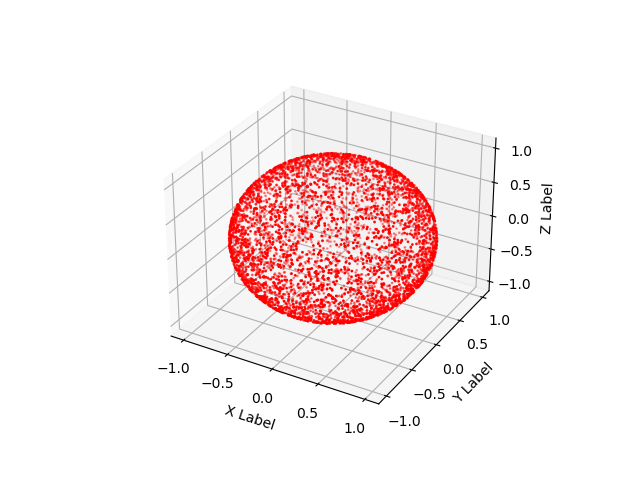

In [11]:
%matplotlib notebook
plot_list_angles(*get_list_angles(N=5000))